In [1]:
!pip install torchsummary

# Import the necessary Packages

In [2]:
import torch
import numpy as np
from PIL import Image
import pathlib
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.utils.data as data
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.models as models
from torchsummary import summary
from sklearn.metrics import classification_report


num_epochs = 3
print(torch.__version__)
print(torch.cuda.is_available())

1.13.0
True


### Gravics card

In [3]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Mon_May__3_19:15:13_PDT_2021
Cuda compilation tools, release 11.3, V11.3.109
Build cuda_11.3.r11.3/compiler.29920130_0


# Load the image

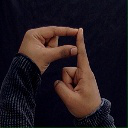

In [4]:
# Load image
img = Image.open('/kaggle/input/sign-language/Sign Language images/P/0.jpg')
img

In [5]:
# Convert image to NumPy array
img_array = np.asarray(img)

# Print array shape
print(img_array.shape)

(128, 128, 3)


In [6]:
# Image directory
Image_dirs = '/kaggle/input/sign-language/Sign Language images/'
data_dir   = pathlib.Path(Image_dirs)

# List of all files in the directory and its subdirectories
image_path = list(data_dir.glob('*/*.jpg'))

# total number of image files
image_count = len(image_path)

# Unique labels
Labels = list(set(p.parent.name for p in image_path))
print('Labels :',sorted(Labels))
num_labels = len(Labels)

# Print the results
print(f"Found {image_count} images in {num_labels} unique labels")

Labels : ['1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
Found 42000 images in 35 unique labels


# Preprocessing

In [7]:
# Define the transforms to apply to the images
transforms = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize the image to 128x128 pixels
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=30),   # Rotate the image randomly up to 30 degrees
    transforms.RandomAffine(degrees=0, shear=45),   # Apply affine transformation with shear up to 30 degrees
    transforms.ToTensor(),    # Convert the image to a tensor
#     transforms.Normalize(mean=[0.5, 0.5, 0.5],
#                          std=[0.5, 0.5, 0.5])  # Normalize the pixel values
])


# ImageFolder dataset for the full dataset
full_dataset = datasets.ImageFolder(Image_dirs, transform=transforms)

# Split the dataset into training and testing sets
train_size = int(0.75 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = data.random_split(full_dataset, [train_size, test_size])

# Print the number of images in each set
print(f"Found {len(train_dataset)} images in the training set")
print(f"Found {len(test_dataset)} images in the testing set")

Found 31500 images in the training set
Found 10500 images in the testing set


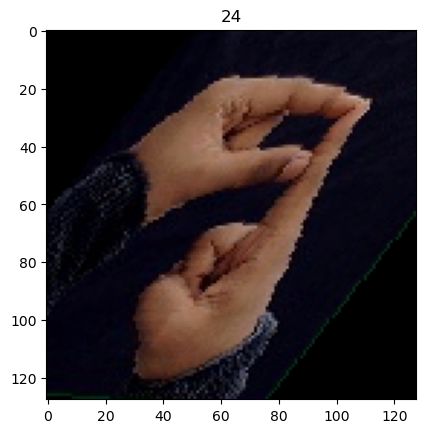

In [8]:
index = 7
img, label = train_dataset[index]
# Convert the PyTorch tensor to a NumPy array
img = img.numpy().transpose((1, 2, 0))
plt.title(label)
plt.imshow(img)
plt.show()

# Build the Model

In [9]:
class Sign_Language(nn.Module):
    def __init__(self):
        super(Sign_Language, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 16 * 16, 512)
        self.relu4 = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(512, 35)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.pool3(x)
        x = x.view(-1, 128 * 16 * 16)
        x = self.fc1(x)
        x = self.relu4(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x
    
model = Sign_Language()

In [10]:
# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the GPU if available
model.to(device)
summary(model, (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
       BatchNorm2d-2         [-1, 32, 128, 128]              64
              ReLU-3         [-1, 32, 128, 128]               0
         MaxPool2d-4           [-1, 32, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          18,496
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
         MaxPool2d-8           [-1, 64, 32, 32]               0
            Conv2d-9          [-1, 128, 32, 32]          73,856
      BatchNorm2d-10          [-1, 128, 32, 32]             256
             ReLU-11          [-1, 128, 32, 32]               0
        MaxPool2d-12          [-1, 128, 16, 16]               0
           Linear-13                  [-1, 512]      16,777,728
             ReLU-14                  [

In [11]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [12]:
# Define the data loaders
batch_size = 50
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [13]:
# Train the model
for epoch in range(num_epochs):
    train_loss = 0.0
    train_acc = 0.0
    
    # Set the model to training mode
    model.train()
    
    for i, (images, labels) in enumerate(train_loader):
        # Move the data to the GPU if available
        images = images.to(device)
        labels = labels.to(device)

        # Clear the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Update the training loss and accuracy
        train_loss += loss.item() * images.size(0)
        Max_val, pred_max_label =torch.max(outputs.data, 1)

     
        train_acc += (pred_max_label == labels).sum().item()            

    train_loss /= len(train_loader.dataset)
    train_acc /= len(train_loader.dataset)
    
    # Evaluate the model on the test set
    test_loss = 0.0
    test_acc = 0.0
    
    # Set the model to evaluation mode
    model.eval()
    
    with torch.no_grad():
        for images, labels in test_loader:
            # Move the data to the GPU if available
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Update the test loss and accuracy
            test_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            test_acc += (predicted == labels).sum().item()
        
        test_loss /= len(test_loader.dataset)
        test_acc /= len(test_loader.dataset)
    
    # Print the epoch statistics
    print("Epoch {}, Train Loss: {:.4f}, Train Acc: {:.4f}, Test Loss: {:.4f}, Test Acc: {:.4f}".format(
        epoch+1,
        train_loss, 
        train_acc, 
        test_loss, 
        test_acc))

Epoch 1, Train Loss: 1.0391, Train Acc: 0.7276, Test Loss: 0.0089, Test Acc: 0.9982
Epoch 2, Train Loss: 0.2436, Train Acc: 0.9144, Test Loss: 0.0022, Test Acc: 0.9993
Epoch 3, Train Loss: 0.1915, Train Acc: 0.9342, Test Loss: 0.0009, Test Acc: 0.9998


In [14]:
# Set the model to evaluation mode
model.eval()

# Get the predicted labels and true labels for the test set
predicted_labels = []
true_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        # Move the data to the GPU if available
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        # Append the predicted and true labels to the lists
        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

In [15]:
Labels_index = {value: key for key, value in full_dataset.class_to_idx.items()}

# Generate the classification report
target_names = [Labels_index[i] for i in range(len(Labels))]
print(classification_report(true_labels, predicted_labels, target_names=target_names))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00       306
           2       1.00      1.00      1.00       307
           3       1.00      1.00      1.00       281
           4       1.00      1.00      1.00       303
           5       0.97      1.00      0.99       302
           6       1.00      1.00      1.00       334
           7       1.00      1.00      1.00       324
           8       1.00      0.97      0.99       286
           9       1.00      1.00      1.00       288
           A       1.00      1.00      1.00       302
           B       1.00      1.00      1.00       306
           C       1.00      1.00      1.00       280
           D       1.00      1.00      1.00       285
           E       1.00      1.00      1.00       297
           F       1.00      1.00      1.00       294
           G       1.00      1.00      1.00       306
           H       1.00      1.00      1.00       282
           I       1.00    

In [16]:
# Define the model file path
model_file = 'mymodel.pt'

# Save the model
torch.save(model, model_file)

In [17]:
# Define the path to the saved model
path = "/kaggle/working/mymodel.pt"

# Load the model
Model = torch.load(path)
Model.to(device)

Sign_Language(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=32768, out_features=512, bias=True)
  (relu4): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=512, out_features=35,

torch.Size([1, 3, 128, 128])


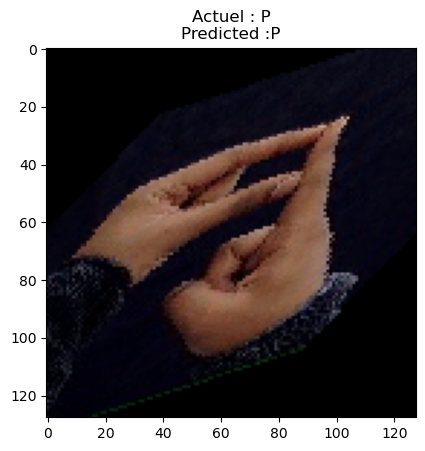

In [18]:
img_path = '/kaggle/input/sign-language/Sign Language images/P/0.jpg'
img = Image.open(img_path)
# Apply the transform to the image
img = transforms(img)
plt.imshow(img.permute(1, 2, 0))
img = img.to(device).unsqueeze(0)  # add batch dimension
print(img.shape)

# Pass the transformed image to the model
output = Model(img)
Max_val, label =torch.max(output.data, 1)
# Reverse the dictionary
Labels_index = {value: key for key, value in full_dataset.class_to_idx.items()}

plt.title('Actuel : {}\nPredicted :{}'.format(img_path.split('/')[-2],
                                       Labels_index[label.item()]))
plt.show()

## ResNet50

In [19]:
# Load the pre-trained ResNet50 model
Resnet50 = models.resnet50(pretrained=True)

# Freeze all parameters in the model
for param in Resnet50.parameters():
    param.requires_grad = False

# Replace the final layer with a new, untrained linear layer
num_features = Resnet50.fc.in_features
Resnet50.fc = torch.nn.Linear(num_features, 35)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(Resnet50.parameters(), lr=0.001)

# Set the device to use
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
Resnet50 = Resnet50.to(device)
summary(Resnet50,(3,128,128))

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           9,408
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]           4,096
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
           Conv2d-11          [-1, 256, 32, 32]          16,384
      BatchNorm2d-12          [-1, 256, 32, 32]             512
           Conv2d-13          [-1, 256, 32, 32]          16,384
      BatchNorm2d-14          [-1, 256,

In [20]:
# Train the model
for epoch in range(num_epochs):
    train_loss = 0.0
    train_acc = 0.0
    
    # Set the model to training mode
    Resnet50.train()
    
    for i, (images, labels) in enumerate(train_loader):
        # Move the data to the GPU if available
        images = images.to(device)
        labels = labels.to(device)

        # Clear the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = Resnet50(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Update the training loss and accuracy
        train_loss += loss.item() * images.size(0)
        Max_val, pred_max_label =torch.max(outputs.data, 1)

     
        train_acc += (pred_max_label == labels).sum().item()            

    train_loss /= len(train_loader.dataset)
    train_acc /= len(train_loader.dataset)
    
    # Evaluate the model on the test set
    test_loss = 0.0
    test_acc = 0.0
    
    # Set the model to evaluation mode
    Resnet50.eval()
    
    with torch.no_grad():
        for images, labels in test_loader:
            # Move the data to the GPU if available
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = Resnet50(images)
            loss = criterion(outputs, labels)
            
            # Update the test loss and accuracy
            test_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            test_acc += (predicted == labels).sum().item()
        
        test_loss /= len(test_loader.dataset)
        test_acc /= len(test_loader.dataset)
    
    # Print the epoch statistics
    print("Epoch {}, Train Loss: {:.4f}, Train Acc: {:.4f}, Test Loss: {:.4f}, Test Acc: {:.4f}".format(
        epoch+1,
        train_loss, 
        train_acc, 
        test_loss, 
        test_acc))

Epoch 1, Train Loss: 0.2797, Train Acc: 0.9602, Test Loss: 0.0404, Test Acc: 0.9957
Epoch 2, Train Loss: 0.0359, Train Acc: 0.9952, Test Loss: 0.0175, Test Acc: 0.9983
Epoch 3, Train Loss: 0.0226, Train Acc: 0.9965, Test Loss: 0.0157, Test Acc: 0.9971


In [21]:
# Set the model to evaluation mode
Resnet50.eval()

# Get the predicted labels and true labels for the test set
predicted_labels = []
true_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        # Move the data to the GPU if available
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = Resnet50(images)
        _, predicted = torch.max(outputs.data, 1)
        
        # Append the predicted and true labels to the lists
        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

In [22]:
Labels_index = {value: key for key, value in full_dataset.class_to_idx.items()}

# Generate the classification report
target_names = [Labels_index[i] for i in range(len(Labels))]
print(classification_report(true_labels, predicted_labels, target_names=target_names))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00       306
           2       1.00      1.00      1.00       307
           3       1.00      1.00      1.00       281
           4       1.00      0.99      1.00       303
           5       0.99      1.00      0.99       302
           6       1.00      1.00      1.00       334
           7       1.00      1.00      1.00       324
           8       1.00      0.99      1.00       286
           9       1.00      1.00      1.00       288
           A       1.00      1.00      1.00       302
           B       1.00      1.00      1.00       306
           C       1.00      0.98      0.99       280
           D       1.00      0.99      0.99       285
           E       0.99      0.99      0.99       297
           F       1.00      1.00      1.00       294
           G       1.00      1.00      1.00       306
           H       1.00      0.99      0.99       282
           I       0.99    

In [23]:
# Define the model file path
model_file = 'Resnet50.pt'

# Save the model
torch.save(Resnet50, model_file)

In [24]:
# Define the path to the saved model
path = "/kaggle/working/Resnet50.pt"

# Load the model
Resnet = torch.load(path)
Resnet.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

torch.Size([1, 3, 128, 128])


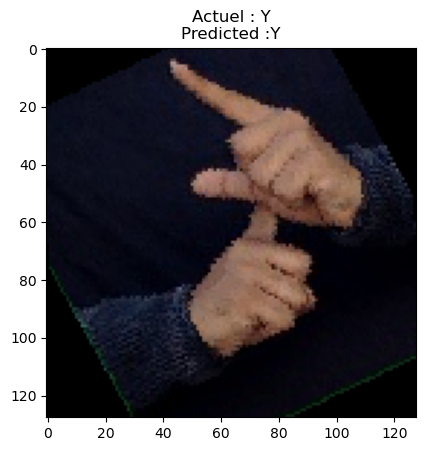

In [25]:
img_path = '/kaggle/input/sign-language/Sign Language images/Y/23.jpg'
img = Image.open(img_path)
# Apply the transform to the image
img = transforms(img)
plt.imshow(img.permute(1, 2, 0))
img = img.to(device).unsqueeze(0)  # add batch dimension
print(img.shape)

# Pass the transformed image to the model
output = Resnet(img)
Max_val, label =torch.max(output.data, 1)
# Reverse the dictionary
Labels_index = {value: key for key, value in full_dataset.class_to_idx.items()}

plt.title('Actuel : {}\nPredicted :{}'.format(img_path.split('/')[-2],
                                       Labels_index[label.item()]))
plt.show()

# ResNet18

In [26]:
# Use the ResNet-18 model
Resnet18 = models.resnet18(pretrained=True)

# Replace the last fully connected layer with a new layer with the number of classes in the dataset
num_classes = 35
Resnet18.fc = nn.Linear(512, num_classes)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(Resnet18.parameters(), lr=0.001)

# Set the device to use
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
Resnet18 = Resnet18.to(device)
summary(Resnet18,(3,128,128))

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           9,408
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
       BasicBlock-11           [-1, 64, 32, 32]               0
           Conv2d-12           [-1, 64, 32, 32]          36,864
      BatchNorm2d-13           [-1, 64, 32, 32]             128
             ReLU-14           [-1, 64,

In [27]:
# Train the model
for epoch in range(num_epochs):
    train_loss = 0.0
    train_acc = 0.0
    
    # Set the model to training mode
    Resnet18.train()
    
    for i, (images, labels) in enumerate(train_loader):
        # Move the data to the GPU if available
        images = images.to(device)
        labels = labels.to(device)

        # Clear the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = Resnet18(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Update the training loss and accuracy
        train_loss += loss.item() * images.size(0)
        Max_val, pred_max_label =torch.max(outputs.data, 1)

     
        train_acc += (pred_max_label == labels).sum().item()            

    train_loss /= len(train_loader.dataset)
    train_acc /= len(train_loader.dataset)
    
    # Evaluate the model on the test set
    test_loss = 0.0
    test_acc = 0.0
    
    # Set the model to evaluation mode
    Resnet18.eval()
    
    with torch.no_grad():
        for images, labels in test_loader:
            # Move the data to the GPU if available
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = Resnet18(images)
            loss = criterion(outputs, labels)
            
            # Update the test loss and accuracy
            test_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            test_acc += (predicted == labels).sum().item()
        
        test_loss /= len(test_loader.dataset)
        test_acc /= len(test_loader.dataset)
    
    # Print the epoch statistics
    print("Epoch {}, Train Loss: {:.4f}, Train Acc: {:.4f}, Test Loss: {:.4f}, Test Acc: {:.4f}".format(
        epoch+1,
        train_loss, 
        train_acc, 
        test_loss, 
        test_acc))

Epoch 1, Train Loss: 0.0638, Train Acc: 0.9842, Test Loss: 0.0333, Test Acc: 0.9900
Epoch 2, Train Loss: 0.0224, Train Acc: 0.9936, Test Loss: 0.2632, Test Acc: 0.9434
Epoch 3, Train Loss: 0.0155, Train Acc: 0.9960, Test Loss: 0.4481, Test Acc: 0.8702


In [28]:
# Set the model to evaluation mode
Resnet18.eval()

# Get the predicted labels and true labels for the test set
predicted_labels = []
true_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        # Move the data to the GPU if available
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = Resnet18(images)
        _, predicted = torch.max(outputs.data, 1)
        
        # Append the predicted and true labels to the lists
        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

In [29]:
Labels_index = {value: key for key, value in full_dataset.class_to_idx.items()}

# Generate the classification report
target_names = [Labels_index[i] for i in range(num_classes)]
print(classification_report(true_labels, predicted_labels, target_names=target_names))

              precision    recall  f1-score   support

           1       0.88      1.00      0.94       306
           2       0.58      1.00      0.74       307
           3       1.00      0.99      1.00       281
           4       0.77      1.00      0.87       303
           5       1.00      0.46      0.63       302
           6       0.55      1.00      0.71       334
           7       0.92      0.70      0.80       324
           8       0.44      1.00      0.61       286
           9       0.80      0.98      0.88       288
           A       0.99      1.00      1.00       302
           B       1.00      1.00      1.00       306
           C       1.00      0.20      0.33       280
           D       0.58      1.00      0.74       285
           E       0.98      0.64      0.77       297
           F       0.98      0.98      0.98       294
           G       1.00      0.84      0.91       306
           H       1.00      0.99      0.99       282
           I       1.00    

In [30]:
# Define the model file path
model_file = 'Resnet18.pt'

# Save the model
torch.save(Resnet18, model_file)

In [31]:
# Define the path to the saved model
path = "/kaggle/working/Resnet18.pt"

# Load the model
Resnet_18 = torch.load(path)
Resnet_18 = Resnet_18.to(device)

torch.Size([1, 3, 128, 128])


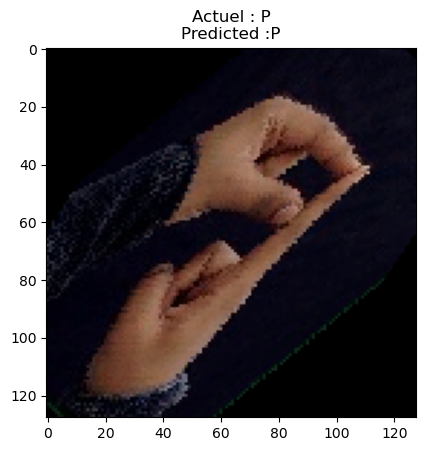

In [32]:
# Apply the transform to the image
img_path = '/kaggle/input/sign-language/Sign Language images/P/0.jpg'

img = Image.open(img_path)
img = transforms(img)
plt.imshow(img.permute(1, 2, 0))
img = img.to(device).unsqueeze(0)  # add batch dimension
print(img.shape)

# Pass the transformed image to the model
output = Resnet_18(img)
Max_val, label =torch.max(output.data, 1)
# Reverse the dictionary
Labels_index = {value: key for key, value in full_dataset.class_to_idx.items()}

plt.title('Actuel : {}\nPredicted :{}'.format(img_path.split('/')[-2],
                                       Labels_index[label.item()]))
plt.show()